In [52]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import lina

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

In [5]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [6]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

# Do the normalization

In [10]:
scoobi.move_psf(-50, 0, client0)

In [12]:
reload(scoobi)
tbi.set_zwo_exp_time(0.00001, client0)

Set the ZWO exposure time to 3.20e-05s


In [13]:
reload(scoobi)
tbi.set_zwo_emgain(120, client0)

Set the ZWO gain setting to 120.0


In [14]:
reload(scoobi)
tbi.set_fib_atten(17, client)

Set the fiber attenuation to 17.0


INFO:utils:Got semaphore index 1.


58033.4


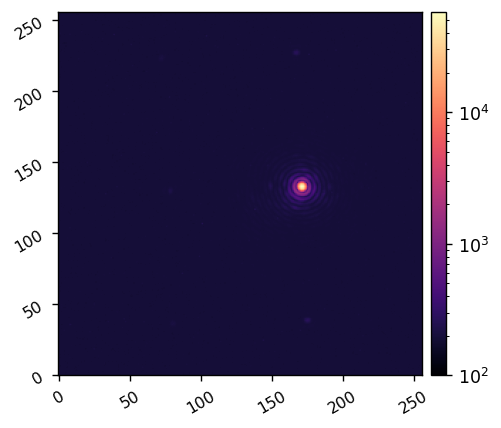

In [15]:
tbi.Nframes = 100
ref_psf = tbi.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [16]:
tbi.Imax_ref = copy.copy(xp.max(ref_psf))
tbi.texp_ref = 3.2e-5
tbi.att_ref = 17
tbi.gain_ref = 120
print(tbi.Imax_ref, tbi.texp_ref, tbi.att_ref, tbi.gain_ref  )

58033.4 3.2e-05 17 120


In [38]:
scoobi.move_psf(2, 0, client0)

In [36]:
scoobi.move_psf(0, 2, client0)

In [25]:
tbi.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [24]:
tbi.set_zwo_exp_time(0.002, client0)

Set the ZWO exposure time to 2.00e-03s


In [120]:
tbi.set_zwo_emgain(120, client0)

Set the ZWO gain setting to 120.0


In [39]:
reload(scoobi)
scoobi.move_block_in(client0)

In [42]:
reload(scoobi)
scoobi.move_block_out(client0)

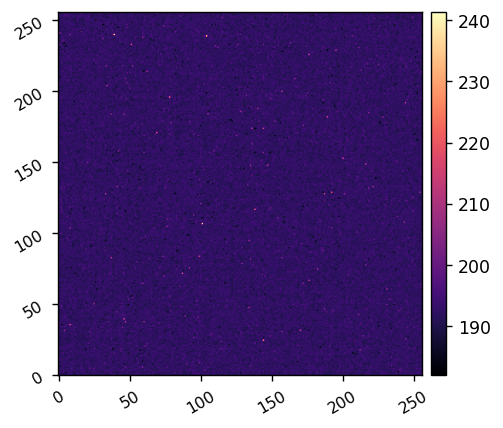

In [41]:
tbi.Nframes = 100
tbi.subtract_dark = False
tbi.return_ni = False
dark_frame = tbi.snap()
imshow1(dark_frame)

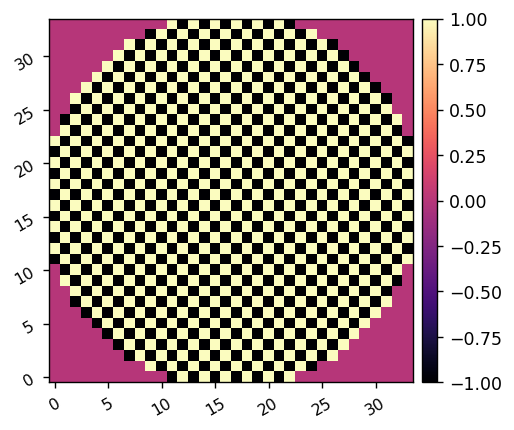

In [46]:
reload(scoobpsf.utils)
waffle_command = scoobpsf.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(tbi.dm_mask)
imshow1(waffle_command)

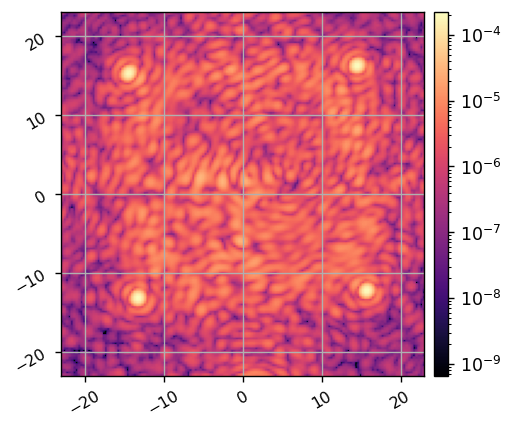

In [47]:
tbi.set_dm(15e-9 * waffle_command)
tbi.x_shift = 0
tbi.y_shift = 0

tbi.subtract_dark = True
tbi.return_ni = True
waffle_im = tbi.snap()
imshow1(waffle_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD, grid=True)

Centroids:
 [[ 31.2740916   31.71837663]
 [ 27.50592699 124.28963362]
 [121.66415726 127.4670241 ]
 [125.51127226  34.74423205]
 [ 31.2740916   31.71837663]]


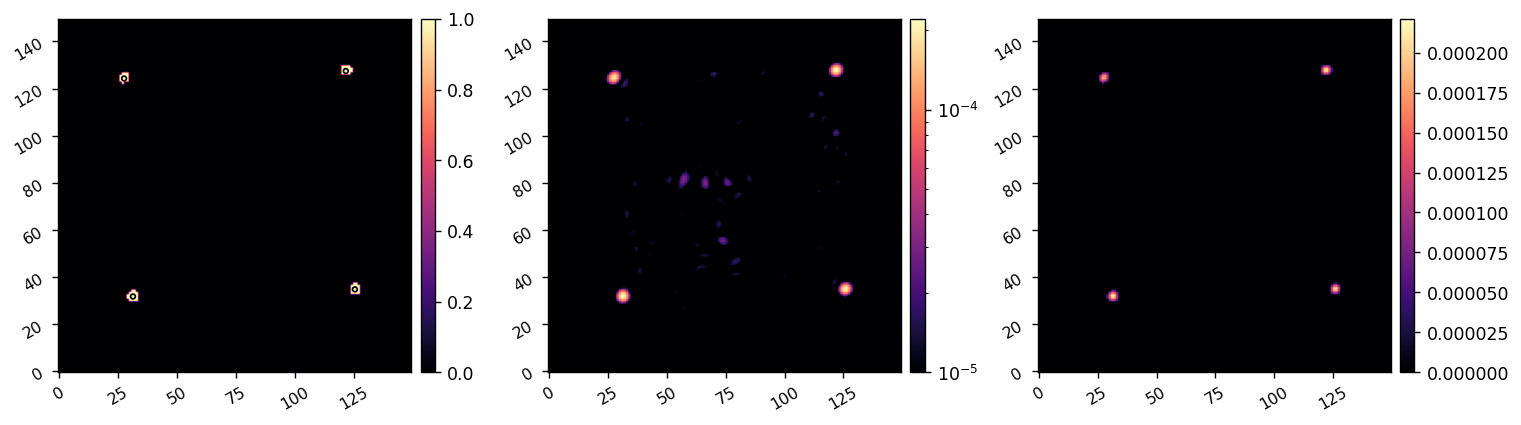

Angle:  87.88034059056749
Measured center in X:  76.44900245706441
Measured center in Y:  79.57138550063765
Required shift in X:  -1.0
Required shift in Y:  -5.0


In [49]:
reload(scoobpsf.utils)

xshift,yshift,angle = scoobpsf.utils.measure_center_and_angle(waffle_im, tbi.psf_pixelscale_lamD, im_thresh=5e-5, r_thresh=15)

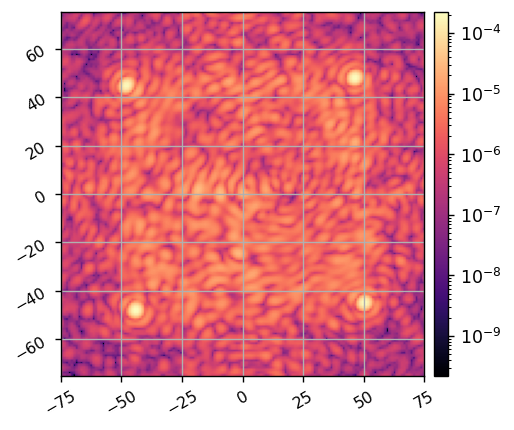

In [50]:
tbi.Nframes = 10
tbi.npsf = 150
tbi.x_shift = xshift
tbi.y_shift = yshift

tbi.df = scoobpsf.utils.pad_or_crop(dark_frame, tbi.npsf)
tbi.subtract_dark = True
tbi.return_ni = True

coro_im = tbi.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

# Choose modes and probes for iEFC

In [55]:
reload(scoobpsf.utils)

control_mask = scoobpsf.utils.create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, iwa=2.5, owa=12, edge=2.5,)

2.935201598026492e-06


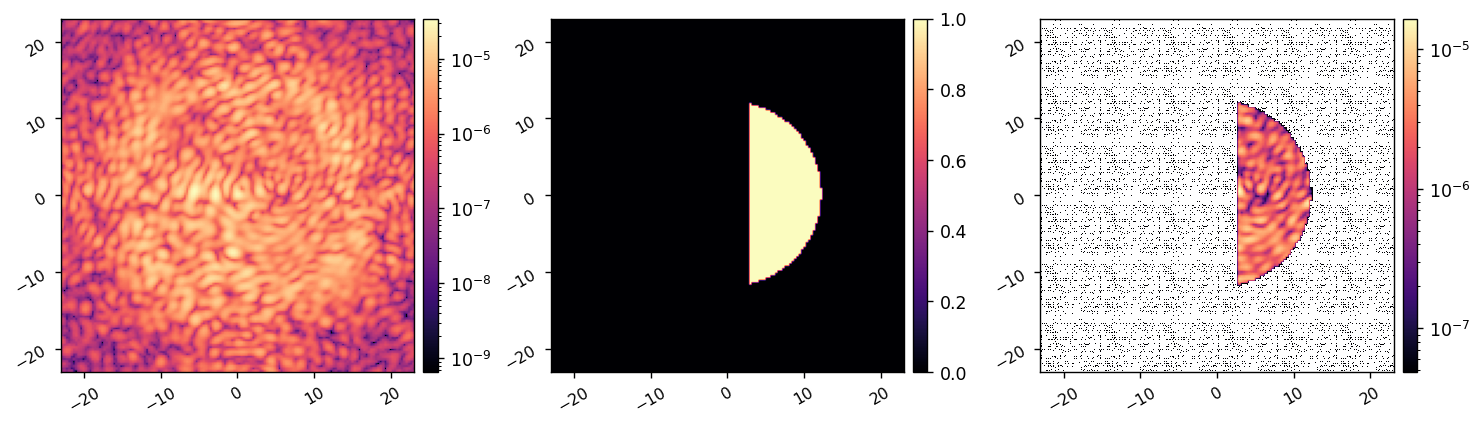

In [56]:
tbi.zero_dm()
tbi.Nframes = 10
tbi.subtract_dark = True
tbi.return_ni = True

ref_coro_im = tbi.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=tbi.psf_pixelscale_lamD)

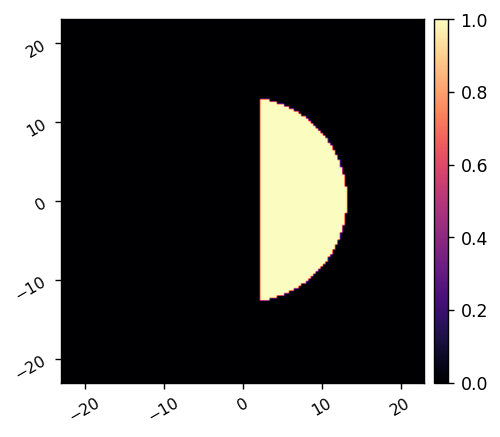

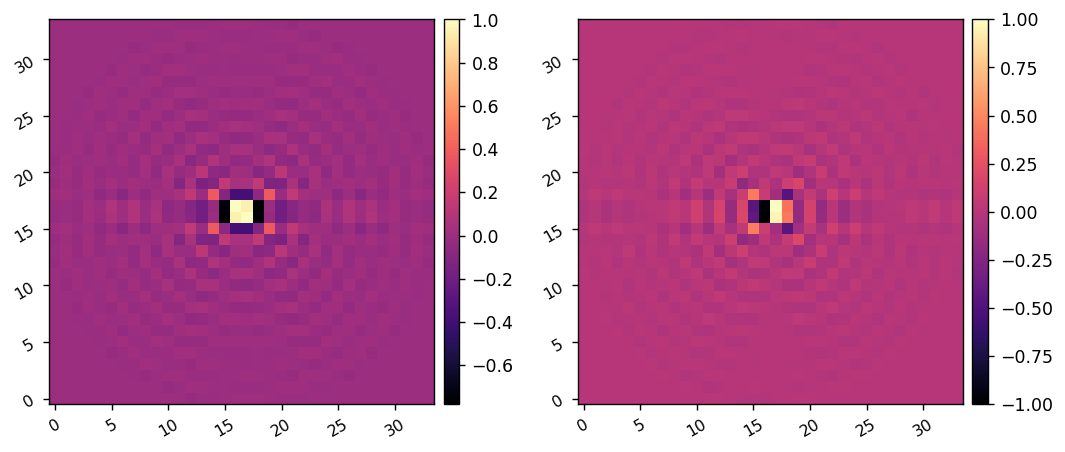

In [57]:
probe_iwa = 2
probe_owa = 13
probe_mask = scoobpsf.utils.create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=2)
imshow1(probe_mask, pxscl=tbi.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(tbi, probe_mask, fourier_sampling=0.25, 
                                             #   shift=[(0,8), (0,-8)], 
                                            #    shift=[(-5,6), (5,6), (0, -5)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               )
imshow2(probe_modes[0], probe_modes[1])
# imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

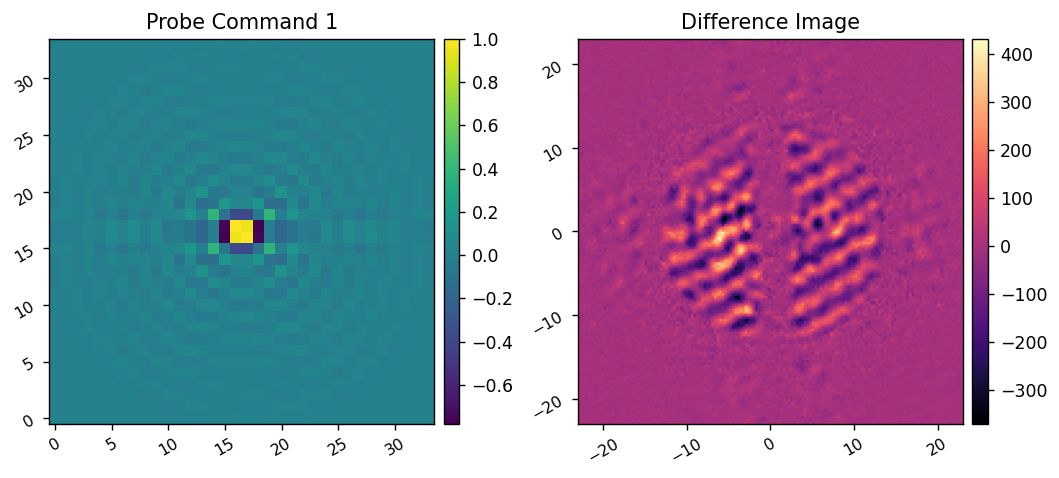

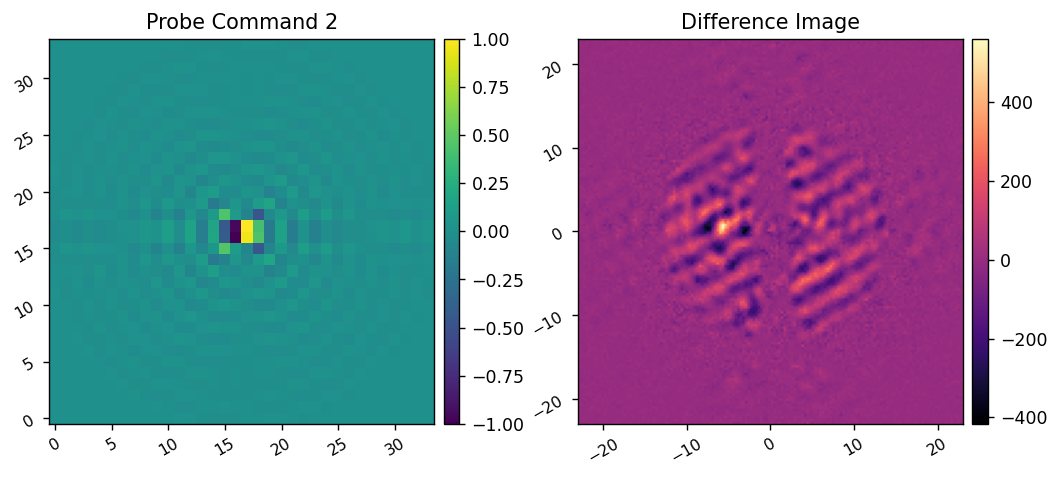

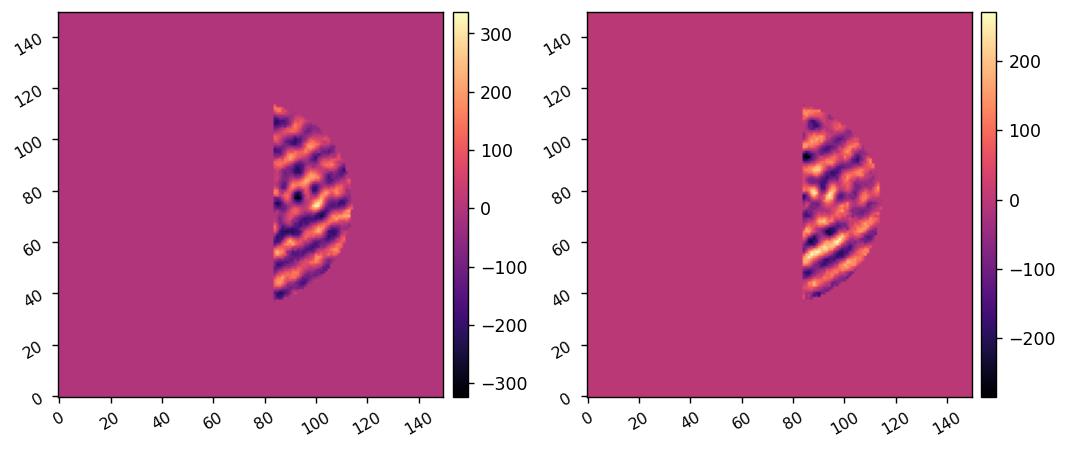

In [58]:
reload(lina.iefc)

tbi.Nframes = 5
tbi.subtract_dark = False
diff_ims = lina.iefc.take_measurement(tbi, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

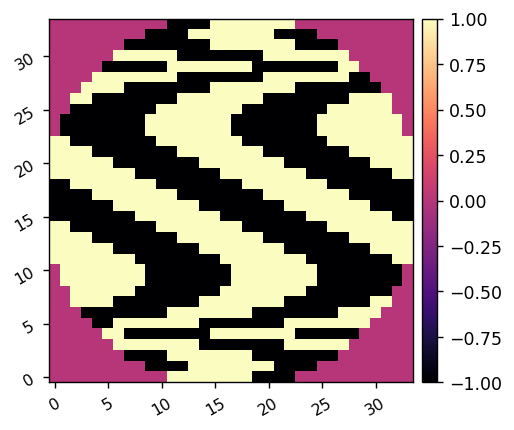

In [59]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(tbi.dm_mask))
imshow1(calib_modes[8].reshape(tbi.Nact, tbi.Nact))


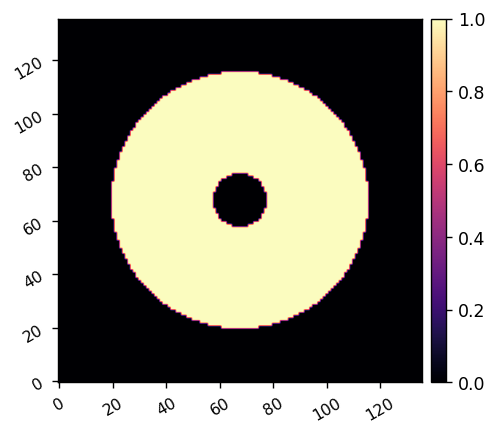

(1024,)


In [88]:
reload(scoobpsf.utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:tbi.Nact**2].reshape(tbi.Nact, tbi.Nact)
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(scoobpsf.utils.pad_or_crop(had_mode, tbi.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))**2

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-tbi.Nact*oversamp//2, tbi.Nact*oversamp//2-1, tbi.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>2.5)*(r<12)
imshow1(mode_freq_mask)

sum_vals = []
max_vals = []
for i in range(calib_modes.shape[0]//2):
    sum_vals.append(xp.sum(mode_freqs[i, mode_freq_mask]))
    max_vals.append(xp.max(mode_freqs[i, mode_freq_mask]))

biggest_sum = xp.max(xp.array(sum_vals))
biggest_max = xp.max(xp.array(max_vals))

scale_factors = []
for i in range(calib_modes.shape[0]//2):
    scale_factors.append((biggest_max/max_vals[i])**(1/3))
    # scale_factors.append(xp.exp(-(biggest_max/max_vals[i]-1)))
scale_factors = ensure_np_array(xp.array(scale_factors))
# scale_factors[scale_factors>2] = 2
# scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

In [89]:
scale_factors[scale_factors>5] = 5
scale_factors[8:12] * 2

array([2.87065747, 7.50207487, 4.55972953, 4.99542908])

In [122]:
tbi.zero_dm()

Calibrating iEFC...
	Calibrated mode 1024/1024 in 2481.756s
Calibration complete.


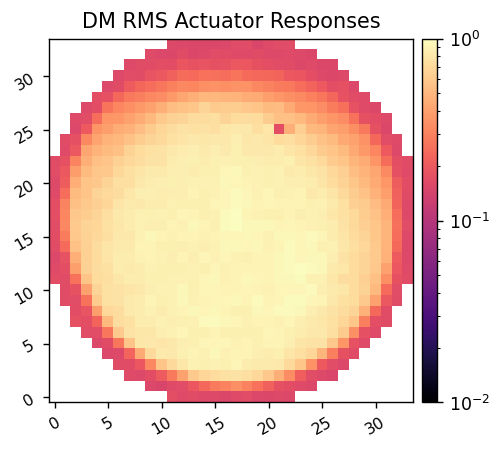

In [91]:
reload(lina.iefc)
tbi.zero_dm()

probe_amp = 5e-9
calib_amp = 2e-9

tbi.Nframes = 5
tbi.return_ni = True
tbi.subtract_dark = False
time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(tbi, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, 
                                                     scale_factors=scale_factors, 
                                                    #  calib_amp, calib_modes[8:12], 
                                                    #  scale_factors=scale_factors[8:12], 
                                                     return_all=True,
                                                     )

In [92]:
lina.utils.save_fits('data/iefc_hadamard_jac_20240730.fits', response_matrix)
lina.utils.save_fits('data/iefc_hadamard_jac_cube_20240730.fits', response_cube)

Saved data to:  data/iefc_hadamard_jac_20240730.fits
Saved data to:  data/iefc_hadamard_jac_cube_20240730.fits


In [144]:
tbi.texp

0.0020000000949949

In [131]:
tbi.set_zwo_exp_time(0.2, client0, delay=1)
tbi.set_zwo_emgain(300, client0)
tbi.Nframes = 10

Set the ZWO exposure time to 2.00e-01s
Set the ZWO gain setting to 300.0


In [132]:
reload(scoobi)
scoobi.move_block_in(client0)

In [134]:
reload(scoobi)
scoobi.move_block_out(client0)

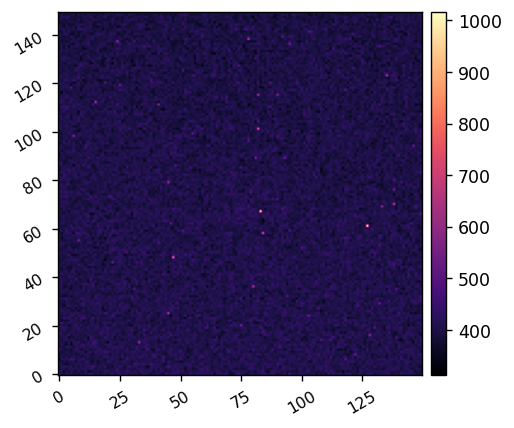

In [133]:
tbi.Nframes = 50
tbi.subtract_dark = False
tbi.return_ni = False
dark_frame = tbi.snap()
imshow1(dark_frame)

tbi.df = copy.copy(dark_frame)

8.897282218586364e-09


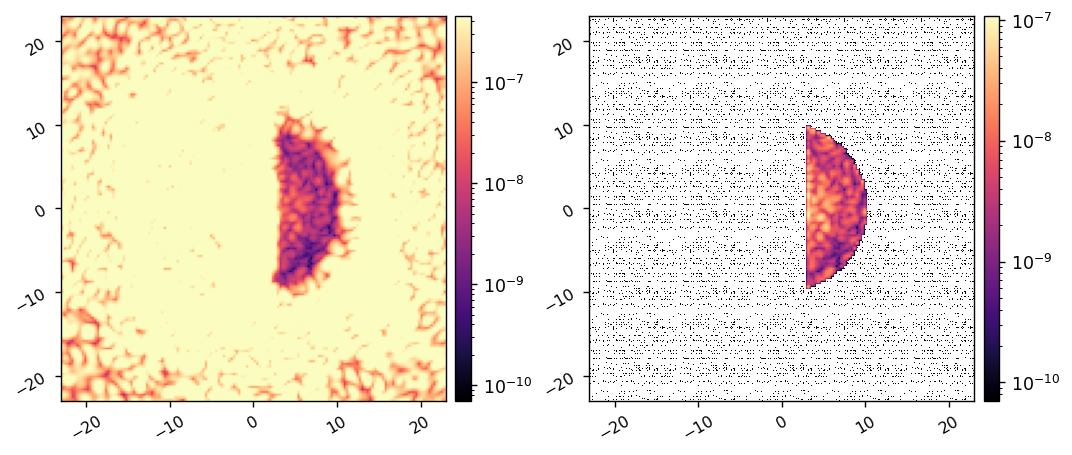

In [136]:
tbi.Nframes = 10
tbi.subtract_dark = True
tbi.return_ni = True
# tbi.y_shift = -8

coro_im = tbi.snap()
# print(xp.mean(coro_im[control_mask]))
# imshow2(coro_im, control_mask * coro_im,
#         lognorm=True, pxscl=tbi.psf_pixelscale_lamD)
print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im,
        lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

In [141]:
lina.utils.save_fits('data/iefc_hadamard_ims_20240730.fits', xp.array(all_ims))
lina.utils.save_fits('data/iefc_hadamard_commands_20240730.fits', xp.array(all_commands))

Saved data to:  data/iefc_hadamard_ims_20240730.fits
Saved data to:  data/iefc_hadamard_commands_20240730.fits


In [100]:
tbi.zero_dm()
all_ims = []
all_commands = []

Running iEFC...
	Closed-loop iteration 4 / 6


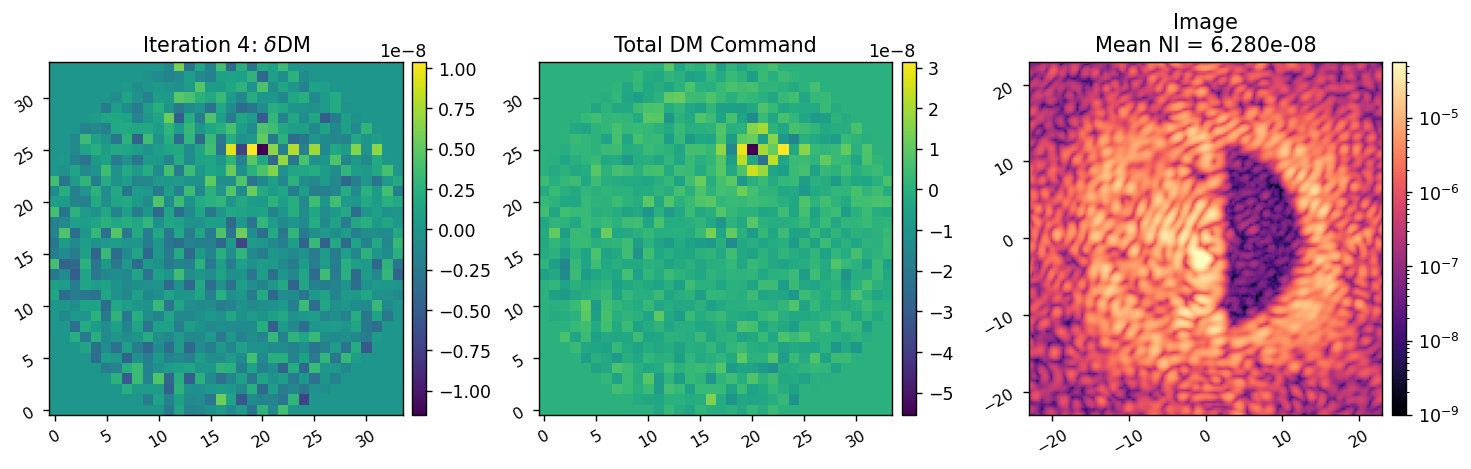

	Closed-loop iteration 5 / 6


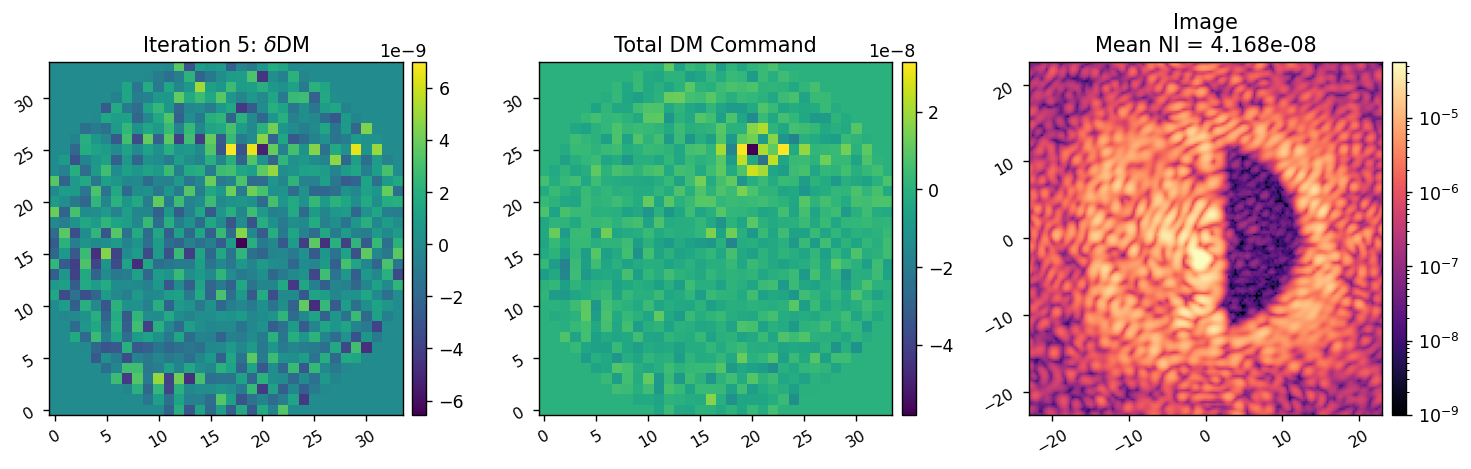

	Closed-loop iteration 6 / 6


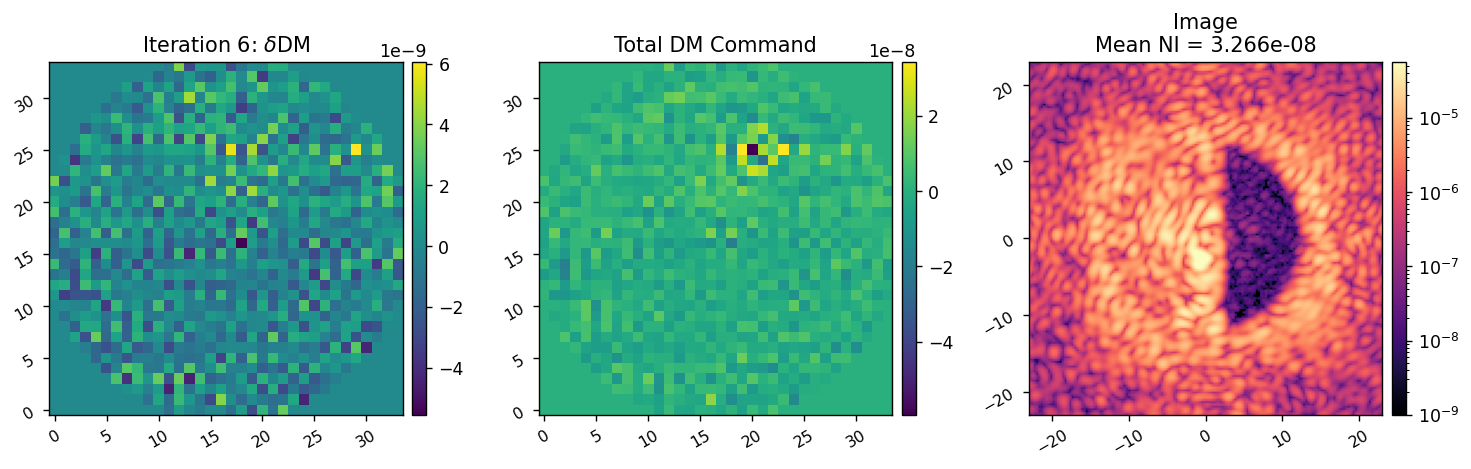

Closed loop for given control matrix completed in 13.502s.


In [102]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
# cm = lina.utils.beta_reg(response_matrix, -3.5)
# cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
# probe_amp = 1e-9

tbi.dm_delay = 0.25

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims,
                                        all_commands=all_commands,
                                        )

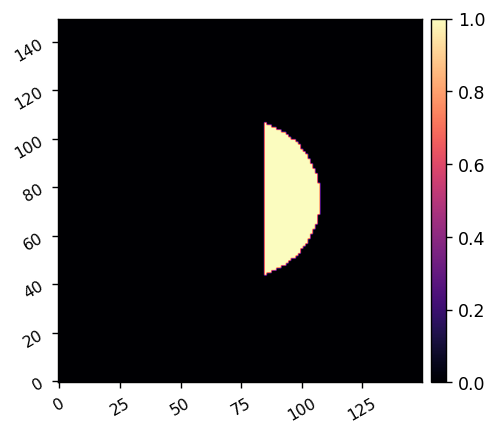

In [124]:
new_control_mask = scoobpsf.utils.create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, iwa=3, owa=10, edge=3,)
imshow1(new_control_mask)

In [125]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2118, 1024)

Running iEFC...
	Closed-loop iteration 28 / 30


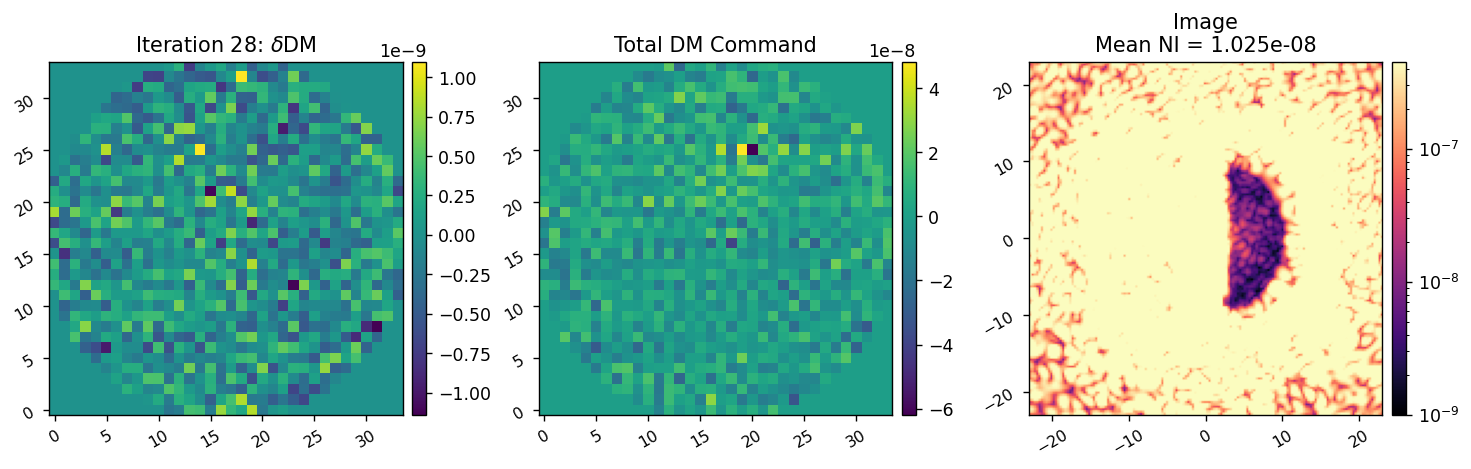

	Closed-loop iteration 29 / 30


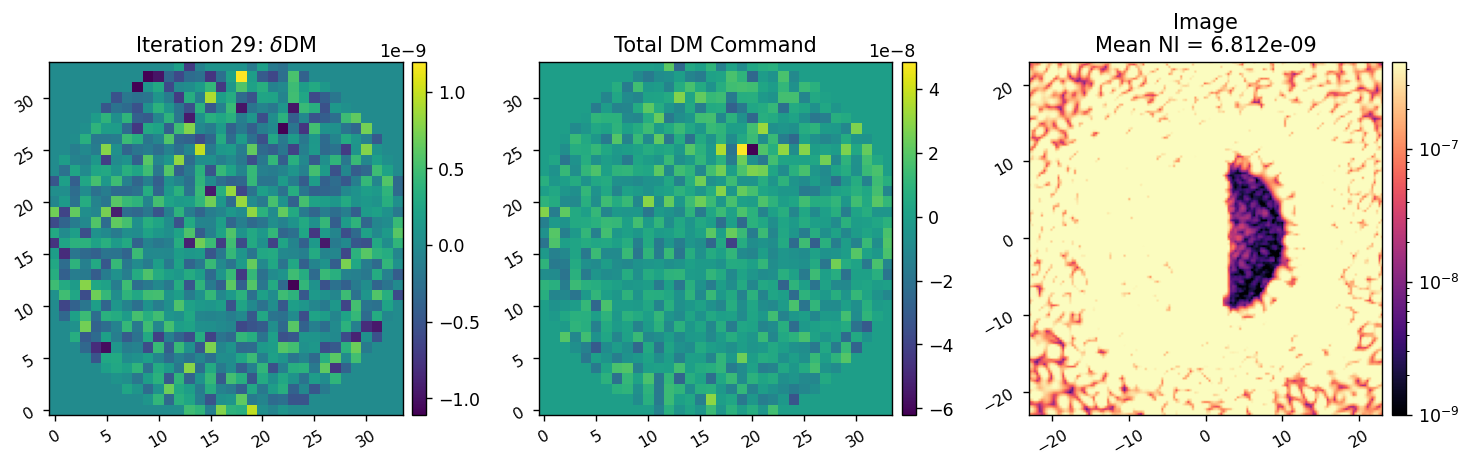

	Closed-loop iteration 30 / 30


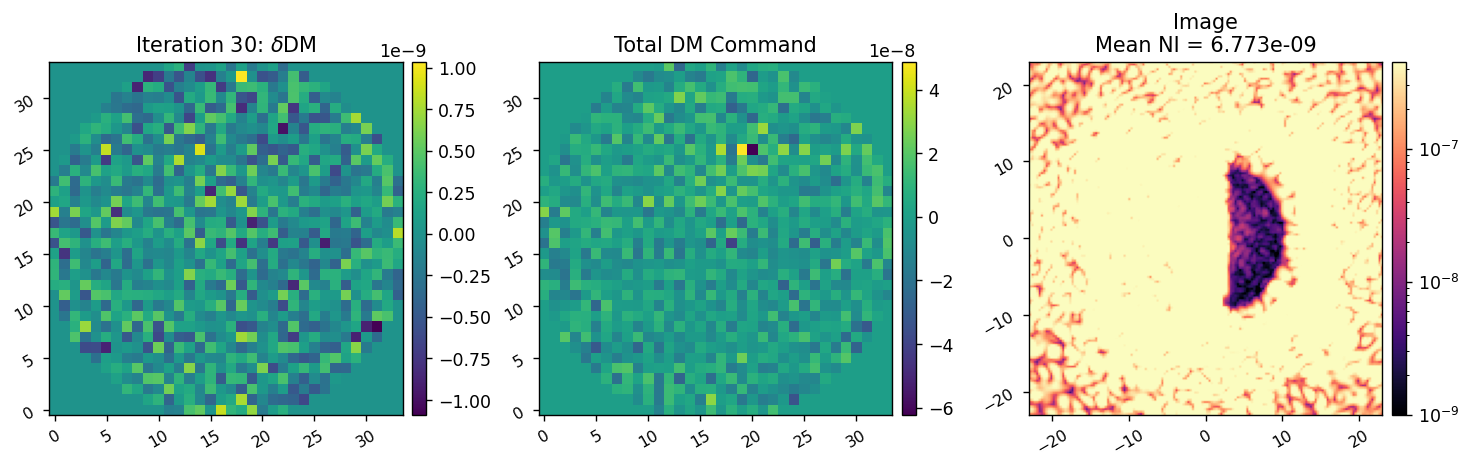

Closed loop for given control matrix completed in 48.215s.


In [140]:
reload(lina.utils)
reload(lina.iefc)

tbi.Nframes = 10

cm = lina.utils.beta_reg(new_response_matrix, -2.5)
# cm = lina.utils.beta_reg(new_response_matrix, -3.5)
# cm = lina.utils.beta_reg(new_response_matrix, -5)

probe_amp = 5e-9
probe_amp = 2.5e-9
probe_amp = 2e-9
probe_amp = 1e-9

tbi.dm_delay = 0.5

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        new_control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

In [149]:
tbi.set_dm(all_commands[-1])

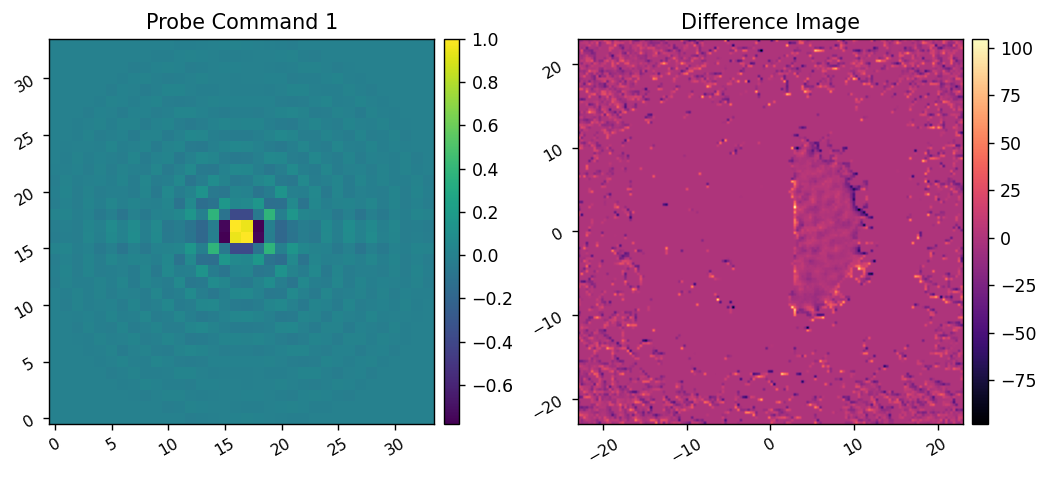

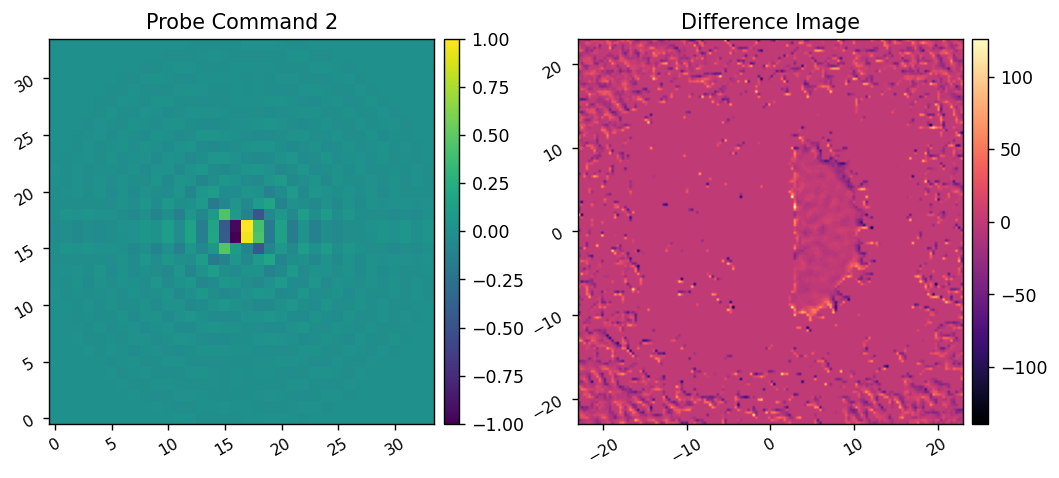

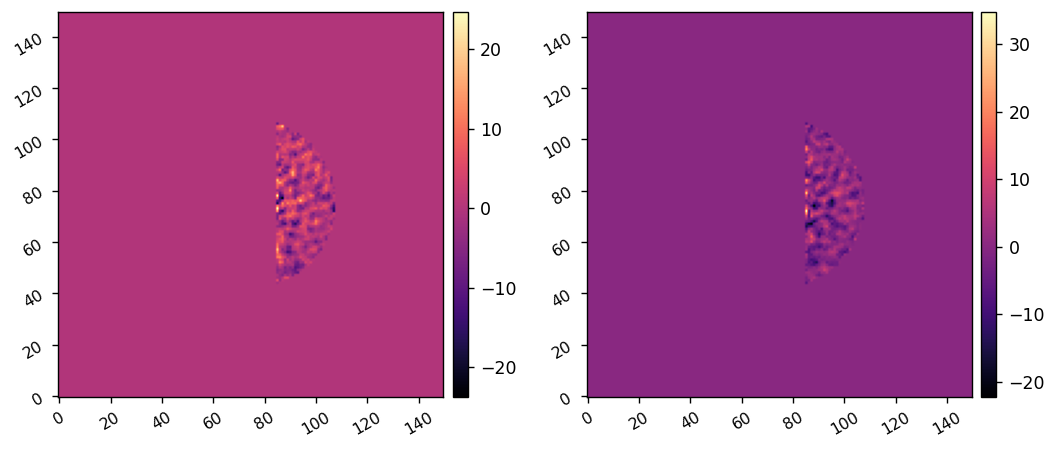

In [152]:
tbi.Nframes = 1
tbi.subtract_dark = False
diff_ims = lina.iefc.take_measurement(tbi, probe_modes, 1e-9, plot=True)
diff_ims *= new_control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

In [156]:
tbi.texp

0.200000002980232

Calibrating iEFC...
	Calibrated mode 1024/1024 in 3711.962s
Calibration complete.


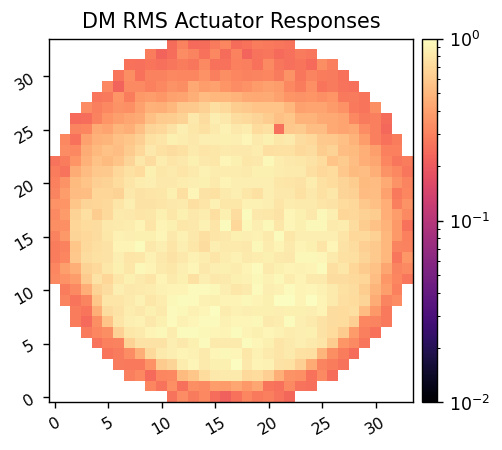

In [157]:
reload(lina.iefc)
# tbi.zero_dm()

probe_amp = 1e-9
calib_amp = 0.15e-9

tbi.dm_delay = 0.05
tbi.Nframes = 2
tbi.return_ni = True
tbi.subtract_dark = False
time.sleep(2)
recalib_matrix, recalib_cube = lina.iefc.calibrate(tbi, new_control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, 
                                                     scale_factors=scale_factors, 
                                                    #  calib_amp, calib_modes[8:12], 
                                                    #  scale_factors=scale_factors[8:12], 
                                                     return_all=True,
                                                     )

1.732919845413433e-08


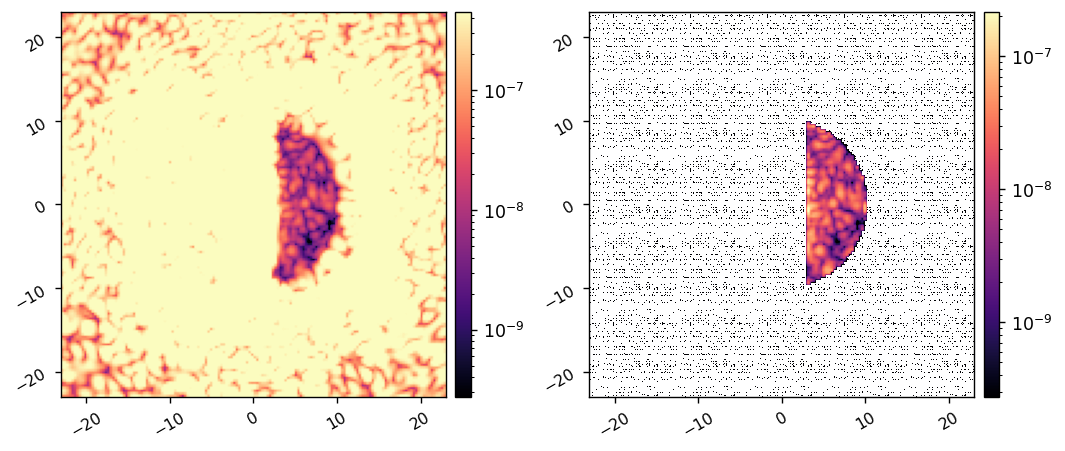

In [159]:
tbi.Nframes = 5
tbi.subtract_dark = True
tbi.return_ni = True
# tbi.y_shift = -8

coro_im = tbi.snap()
# print(xp.mean(coro_im[control_mask]))
# imshow2(coro_im, control_mask * coro_im,
#         lognorm=True, pxscl=tbi.psf_pixelscale_lamD)
print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im,
        lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Running iEFC...
	Closed-loop iteration 40 / 42


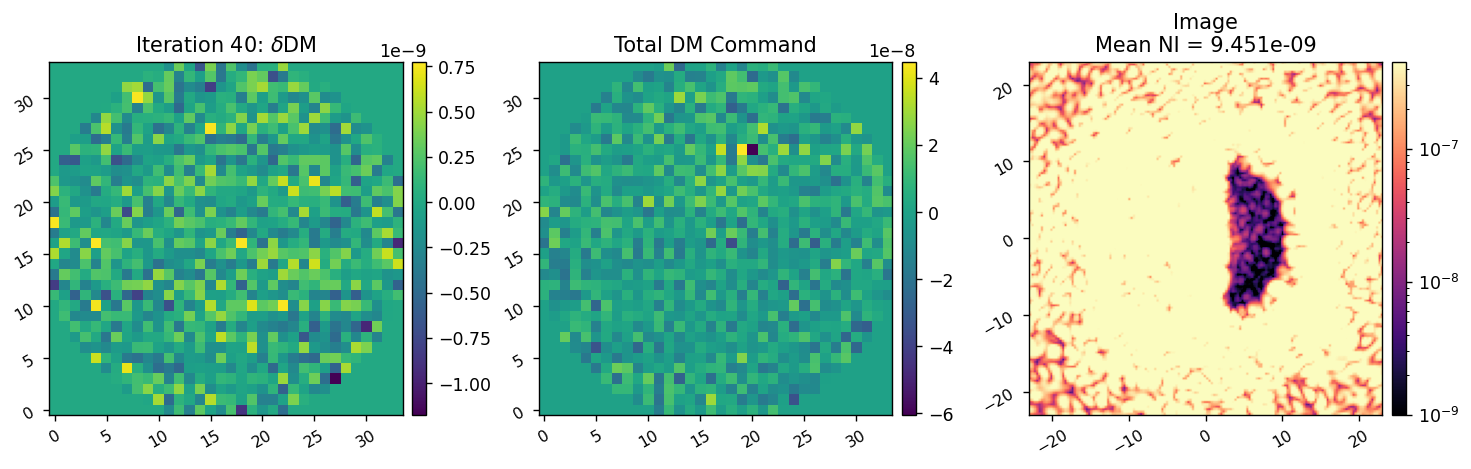

	Closed-loop iteration 41 / 42


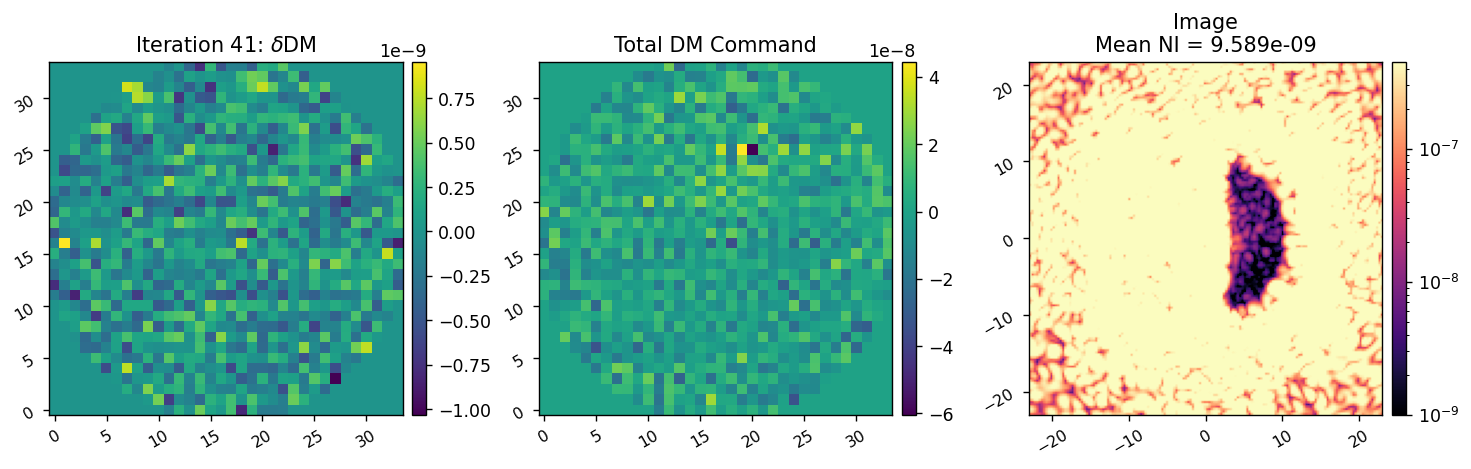

	Closed-loop iteration 42 / 42


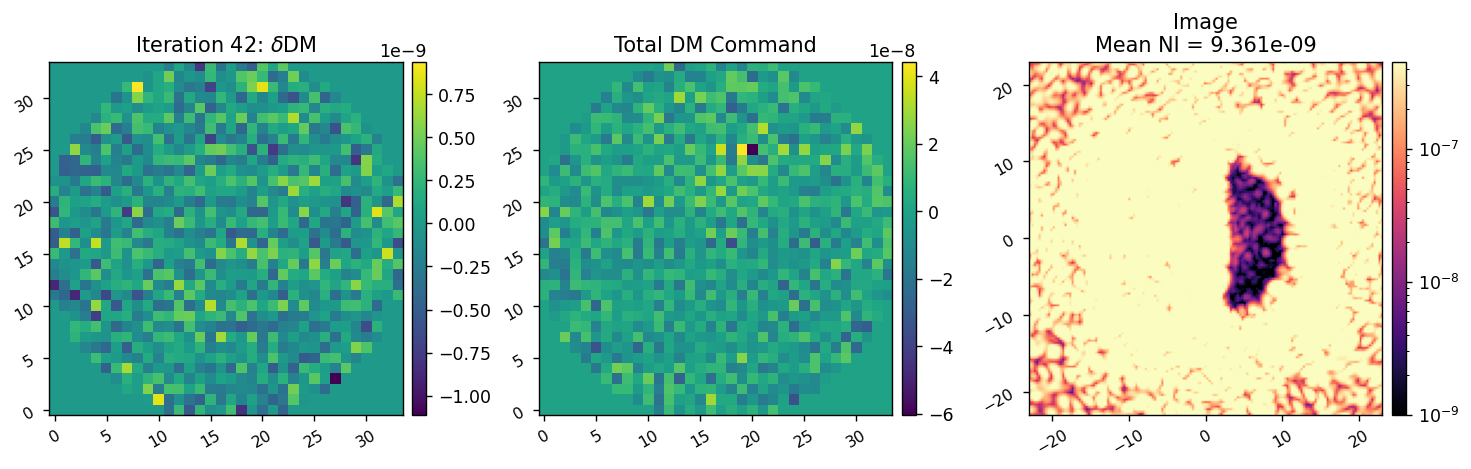

Closed loop for given control matrix completed in 30.118s.


In [164]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(recalib_matrix, -2.5)
# cm = lina.utils.beta_reg(recalib_matrix, -3.5)
# cm = lina.utils.beta_reg(recalib_matrix, -5)

probe_amp = 1e-9
probe_amp = 0.5e-9

tbi.dm_delay = 0.4

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        new_control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims,
                                        all_commands=all_commands,
                                        )

In [165]:
xp.sqrt(xp.mean(xp.square(xp.array(all_commands[-1])[tbi.dm_mask.astype(bool)])))

array(1.12577182e-08)

In [167]:
tbi.set_zwo_exp_time(0.001, client0)
tbi.set_zwo_emgain(120, client0)
tbi.zero_dm()

Set the ZWO exposure time to 1.00e-03s
Set the ZWO gain setting to 120.0
